# Train without normalize

This notebook will use the CHARM view (unbalanced_view_train_test-v1) and will:

1. Apply DFT over dataset windows
2. Train three times with RF, SVM and KNN, and take the average accuracy and f1-score
3. Plot UMAP and T-SNE

In [1]:
from pathlib import Path  # For defining dataset Paths
import sys
sys.path.append("../../..")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
#from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Librep imports
from librep.utils.dataset import PandasDatasetsIO          # For quick load train, test and validation CSVs
from librep.datasets.har.loaders import ExtraSensoryBalancedResampledView20HZ, UCIHARUnbalancedView, WISDMInterpolatedUnbalancedView, CHARMUnbalancedView

from librep.datasets.multimodal import PandasMultiModalDataset, TransformMultiModalDataset, WindowedTransform
from librep.transforms.fft import FFT
from librep.transforms. stats import StatsTransform
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier, SVC, KNeighborsClassifier
from librep.metrics.report import ClassificationReport
from librep.transforms.resampler import SimpleResampler

2022-10-03 19:25:37.800587: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-03 19:25:37.800609: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Datasets to train the manifold

## Load ExtraSensory

In [3]:
# Load ExtraSensory, creating PandasMultiModalDatasets with the correct pre-defined windows
loader = ExtraSensoryBalancedResampledView20HZ("../../../data/views/ExtraSensory/balanced_view_resampled_20hz", download=False)
train_val_es, test_es = loader.load(concat_train_validation=True)
# X_ es = train_val_es.data.iloc
# X_es = train_val_es.data.iloc[:,1:-6]


train_val_es.data.iloc[:,1:-6]

,accelerometer-x-0,accelerometer-x-1,accelerometer-x-2,accelerometer-x-3,accelerometer-x-4,accelerometer-x-5,accelerometer-x-6,accelerometer-x-7,accelerometer-x-8,accelerometer-x-9,...,gyroscope-z-50,gyroscope-z-51,gyroscope-z-52,gyroscope-z-53,gyroscope-z-54,gyroscope-z-55,gyroscope-z-56,gyroscope-z-57,gyroscope-z-58,gyroscope-z-59
0,-0.724789,-0.507973,0.107924,-0.052122,-0.308210,-0.327109,-0.144647,-0.061857,-0.075849,-0.108986,...,-0.029486,0.011534,-0.032998,0.016543,-0.041989,0.027790,-0.045943,0.052013,-0.077395,0.111475
1,-0.013220,-0.019134,-0.002889,-0.008703,0.013098,0.018542,0.009620,0.016564,0.006461,0.004548,...,0.000029,0.004917,-0.018431,0.004122,0.019265,0.014980,0.022228,0.023919,0.028533,0.013692
2,-0.214355,-0.206973,-0.219664,-0.225939,-0.219012,-0.208570,-0.195748,-0.212864,-0.227196,-0.245031,...,0.002744,0.005068,0.010737,0.009596,0.007746,0.004763,0.013354,0.005289,0.002381,0.008331
3,0.761069,0.757731,0.752873,0.753823,0.753913,0.756301,0.758194,0.756618,0.756947,0.756485,...,0.001041,-0.000783,-0.002598,0.001302,0.000400,0.000531,-0.002842,0.000469,0.000963,-0.001895
4,-0.001454,-0.008433,-0.004865,-0.006524,-0.005949,-0.006001,-0.007217,-0.008985,-0.007185,-0.003809,...,-0.001976,-0.000086,-0.000245,0.001119,-0.001033,0.001574,-0.001405,-0.000204,-0.003032,0.002380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1.318814,0.820496,0.829511,1.464799,1.194766,1.340308,0.655106,0.642922,1.672151,1.631894,...,-0.071705,0.560008,0.477855,0.188169,0.514792,-0.305859,-0.512085,-0.384287,-0.300596,-0.197638
140,-3.755993,-2.862513,-2.130942,1.607675,3.116307,2.871448,1.015326,3.089434,5.513042,4.221506,...,-1.275709,-2.031439,-3.953223,-4.451037,-2.519823,-1.071030,-2.209544,-2.579949,-0.775481,0.184701
141,-0.046923,-0.052641,-0.047726,-0.048309,-0.047292,-0.043157,-0.039521,-0.041308,-0.040168,-0.044390,...,-0.006601,-0.004064,0.002956,0.005797,0.001869,-0.003331,0.004593,-0.004651,0.003989,-0.001190
142,-6.725034,-4.565210,-6.688427,-8.245128,-2.401993,6.173494,6.665963,7.925987,2.102236,-0.814744,...,7.413526,2.151802,-1.035741,0.370291,-0.468816,-1.549655,-2.854839,-5.031104,-7.418414,-6.967641


In [4]:
extrasensory_X = np.array(train_val_es.data.iloc[:,1:-6])
extrasensory_Y = np.array(train_val_es.data['activity code'])
tam = len(extrasensory_Y)
extrasensory_id_dataset = np.array(['E']*tam)

## Load UCI-HAR

In [5]:
# Load UCI-HAR, creating PandasMultiModalDatasets with the correct pre-defined windows
loader = UCIHARUnbalancedView("../../../data/views/UCI-HAR/unbalanced_view_train_test-v1", download=False)
train_val_uci, test_uci = loader.load(concat_train_validation=True)

train_val_uci.data['activity code'] = train_val_uci.data['activity code'].astype('int')

In [6]:
# Resampling the dataset to 20 Hz
resampler = SimpleResampler(new_sample_size=60)
transformer = TransformMultiModalDataset(
    transforms=[resampler], new_window_name_prefix="resampled."
)
train_val_uci = transformer(train_val_uci)
test_uci = transformer(test_uci)
# train_uci = pd.DataFrame(train_val_uci.X)
uci_X = train_val_uci.X
uci_Y = train_val_uci.y

tam = len(uci_Y)
uci_id_dataset = np.array(['U']*tam)

## Load WISDM

In [7]:
# Load WISDM and create PandasMultiModalDatasets with the correct pre-defined windows
loader = WISDMInterpolatedUnbalancedView("../../../data/views/WISDM/interpolated_unbalanced_view_train_test-v1", download=False)
train_val_wisdm, test_wisdm = loader.load(concat_train_validation=True)

#rename "activity" with "activity code"
train_val_wisdm.data.rename(columns = {'activity':'activity code'}, inplace = True)
#test.data.rename(columns = {'activity':'activity code'}, inplace = True)

train_val_wisdm.data['activity code'] = train_val_wisdm.data['activity code'].astype('int')


In [8]:
wisdm_X = np.array(train_val_wisdm.data.iloc[:,:-2])
wisdm_Y = np.array(train_val_wisdm.data['activity code'])

tam = len(wisdm_Y)
wisdm_id_dataset = np.array(['W']*tam)

## Load KuHar

In [9]:
# Path for KuHar resampled to 20Hz view with the same activities (and labels numbers)
# It is assumed that the directory will contain (train.csv, test.csv and validation.csv)
#dataset_path = Path("../../../../data/views/KuHar/resampled_view_20Hz")
dataset_path = Path("../../../../data/views/KuHar/resampled_view_20Hz")

In [10]:
train_kh, validation_kh, test_kh = PandasDatasetsIO(dataset_path).load()
train_kh['normalized activity code'].unique()

array([ 1,  0,  6,  7,  8,  9, 10, 11, 12, 13, 14,  2, 15, 16,  5,  3,  4,
       17])

In [11]:
# # Kuhar features to select
# features = [
#     "accel-x",
#     "accel-y",
#     "accel-z",
#     "gyro-x",
#     "gyro-y",
#     "gyro-z"
# ]

# train_kh = train_kh.query("`normalized activity code` == 0 or `normalized activity code` == 1 or `normalized activity code` == 2 or `normalized activity code` == 3  or `normalized activity code` == 4 or `normalized activity code` == 5")
# validation_kh = validation_kh.query("`normalized activity code` == 0 or `normalized activity code` == 1 or `normalized activity code` == 2 or `normalized activity code` == 3  or `normalized activity code` == 4 or `normalized activity code` == 5")
# test_kh = test_kh.query("`normalized activity code` == 0 or `normalized activity code` == 1 or `normalized activity code` == 2 or `normalized activity code` == 3  or `normalized activity code` == 4 or `normalized activity code` == 5")

In [12]:
test_kh.iloc[:,1:-10]

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-50,gyro-z-51,gyro-z-52,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59
0,0.011216,-0.014091,0.023346,-0.046660,0.010339,0.021423,-0.002919,-0.017072,-0.023408,0.005562,...,-0.006564,-0.013314,-0.008751,-0.005504,-0.007862,-0.008045,-0.006388,-0.006671,-0.004199,-0.005945
1,0.004916,0.034297,0.026488,-0.006901,0.029315,0.020227,0.025579,0.015040,0.016612,0.027536,...,0.000529,-0.000628,-0.004678,0.001484,-0.001597,0.000462,0.000871,0.000165,0.000288,-0.002365
2,0.053367,0.035779,-0.016234,0.081826,-0.022036,0.092562,-0.028284,0.043258,0.038537,0.013199,...,-0.010379,-0.000136,-0.007605,-0.004541,0.001959,-0.013335,-0.000956,-0.012968,-0.003183,-0.004695
3,0.023338,0.026330,0.065440,0.015908,0.023099,0.100371,0.023635,-0.011511,-0.006801,0.043358,...,-0.010526,-0.011730,-0.011117,-0.007494,-0.003062,-0.002995,0.002397,0.006776,0.002116,-0.002566
4,-0.043513,0.065625,-0.009443,-0.200732,0.052663,0.080177,-0.031852,-0.029668,-0.093965,0.020673,...,0.006579,0.004492,-0.000554,-0.002524,-0.003588,-0.006182,0.001307,0.003308,0.013341,0.010555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,-7.554215,-2.501182,7.266938,8.585690,9.805514,2.458891,-1.474918,-10.250257,1.422509,-5.051645,...,-0.090831,-0.340729,-0.426176,-0.268531,0.654784,0.691273,0.550959,1.380391,0.799542,0.940237
374,1.713617,2.628069,-2.245347,-2.889998,-3.118331,-3.311320,-2.027414,-0.995071,-0.968020,-1.183561,...,0.239311,0.334281,0.207005,0.260467,-0.077530,-0.126317,-0.596475,-0.260604,-0.282532,0.985005
375,-1.275216,4.213710,4.658013,-1.859007,-9.452015,-5.404795,-4.260726,-2.034139,0.382659,1.237287,...,-0.216900,0.336690,-0.180789,-0.550468,-0.418602,-0.092071,0.269327,0.272439,0.240558,-0.240184
376,0.879875,-2.418700,-2.307421,1.834860,-1.132167,0.166189,0.451129,0.576193,1.311615,-0.003801,...,-0.086819,-0.163030,0.143882,0.107780,0.261684,0.239824,0.369101,0.657196,0.650726,0.609177


In [13]:
train_kh = pd.concat([train_kh, validation_kh])

In [14]:
kuhar_X = np.array(train_kh.iloc[:,1:-10])
kuhar_Y = np.array(train_kh['normalized activity code'])
tam = len(kuhar_Y)
kuhar_id_dataset = np.array(['K']*tam)

## Load MotionSense

In [15]:
dataset_path = Path("../../../../data/views/MotionSense/resampled_view_20Hz")

In [16]:
# Motionsense dataframe
train_motion, validation_motion, test_motion = PandasDatasetsIO(dataset_path).load()
train_motion = pd.concat([train_motion, validation_motion])

In [17]:
test_motion.iloc[:,1:-6]

,userAcceleration.x-0,userAcceleration.x-1,userAcceleration.x-2,userAcceleration.x-3,userAcceleration.x-4,userAcceleration.x-5,userAcceleration.x-6,userAcceleration.x-7,userAcceleration.x-8,userAcceleration.x-9,...,rotationRate.z-50,rotationRate.z-51,rotationRate.z-52,rotationRate.z-53,rotationRate.z-54,rotationRate.z-55,rotationRate.z-56,rotationRate.z-57,rotationRate.z-58,rotationRate.z-59
0,0.131874,0.698120,0.249447,0.278262,0.030374,-0.354742,-1.138250,-0.284650,0.895119,-0.567772,...,-0.364449,0.391488,-0.733558,-1.045904,-0.117149,0.521348,1.869268,-0.696237,-0.464387,0.191062
1,0.307428,0.256560,-0.490041,-0.223831,-0.036877,0.297610,0.078528,0.357304,0.212542,0.065538,...,-0.250703,-0.351724,0.232951,-0.421271,-0.489167,-0.458285,0.128405,1.082841,0.505280,-0.346443
2,-0.003192,-0.089563,-0.255489,-0.105702,-0.034318,0.290096,0.223254,-0.522925,-0.126668,-0.074785,...,1.117978,0.196274,-0.628761,-0.478469,-0.056141,0.640057,0.228042,-0.008930,-0.407200,-0.836208
3,-0.246614,-0.199705,-0.016779,-0.137136,0.002557,0.326433,0.149371,-0.474012,-0.186532,0.059193,...,-0.586675,-0.754723,-0.234760,0.534514,0.267470,-0.507365,-0.155333,1.500232,0.643563,-0.476121
4,-0.012161,0.099850,0.180203,-0.012074,-0.124332,-0.123629,-0.015031,-0.020223,-0.001342,0.072502,...,0.634877,0.016194,0.196007,-0.011190,-0.155632,0.295202,-0.001791,0.251782,0.010536,-0.056862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,-0.053125,-0.417727,0.362315,0.014858,0.479426,0.494016,-0.284822,-0.084017,0.284447,-0.488063,...,-0.764047,1.180779,0.441880,0.174916,-0.226131,-0.378486,-0.337297,0.560125,2.156701,-0.501302
1016,-0.459128,-1.513311,-0.091196,0.414702,-2.691333,-0.519000,1.879917,1.604653,3.055666,-0.343313,...,1.472588,-1.662662,2.929467,-0.275450,8.728854,2.112099,2.112168,-3.248353,-1.771040,-8.619563
1017,-0.099885,-0.062146,0.003534,-0.095406,0.148759,-0.419121,-0.010502,0.108253,0.321862,0.036395,...,1.014984,-0.140049,-0.104440,0.372527,0.798453,-0.187261,-0.351512,-0.024182,-0.266553,-0.811363
1018,0.280130,0.393070,-0.229514,-0.252522,-0.445879,-0.496591,0.516785,1.022505,-0.113360,-0.421121,...,-0.308984,-1.031317,0.376575,0.495909,0.136660,0.423858,-0.294283,0.201025,-0.374531,0.137912


In [18]:
motion_X = np.array(test_motion.iloc[:,1:-6])
motion_Y = np.array(test_motion['normalized activity code'])
tam = len(motion_Y)
motion_id_dataset = np.array(['M']*tam)

## Load CHARM

In [19]:
# Load CHARM, creating PandasMultiModalDatasets with the correct pre-defined windows
loader = CHARMUnbalancedView("../../../data/views/CHARM/unbalanced_view_train_test-v1", download=False)
train_val_charm, test_charm = loader.load(concat_train_validation=True)

#rename "activity" with "activity code"
#train_val.data.rename(columns = {'activity':'activity code'}, inplace = True)
#test.data.rename(columns = {'activity':'activity code'}, inplace = True)

train_val_charm.data['activity code'] = train_val_charm.data['activity code'].astype('int')

In [20]:
#Selecting only classes of interest

test_charm.data = test_charm.data[test_charm.data['activity code'].isin([0, 2, 6, 7, 8, 9])]

# 0: "Sitting in a Chair", 
# 2: "Standing", 
# 6: "Walking", 
# 7: "Running", 
# 8: "Walking Upstairs", 
# 9: "Walking Downstairs"

In [21]:
train_val_charm.data.loc[train_val_charm.data['activity code'] == 0, 'activity code'] = 0
train_val_charm.data.loc[train_val_charm.data['activity code'] == 2, 'activity code'] = 1
train_val_charm.data.loc[train_val_charm.data['activity code'] == 6, 'activity code'] = 2
train_val_charm.data.loc[train_val_charm.data['activity code'] == 7, 'activity code'] = 5
train_val_charm.data.loc[train_val_charm.data['activity code'] == 8, 'activity code'] = 3
train_val_charm.data.loc[train_val_charm.data['activity code'] == 9, 'activity code'] = 4

# 0 - Sit
# 1 - Stand
# 2 - Walk 
# 3 - Upstairs 
# 4 - Downstairs
# 5 - Run/Jogging

In [22]:
test_charm.data.loc[test_charm.data['activity code'] == 0, 'activity code'] = 0
test_charm.data.loc[test_charm.data['activity code'] == 2, 'activity code'] = 1
test_charm.data.loc[test_charm.data['activity code'] == 6, 'activity code'] = 2
test_charm.data.loc[test_charm.data['activity code'] == 7, 'activity code'] = 5
test_charm.data.loc[test_charm.data['activity code'] == 8, 'activity code'] = 3
test_charm.data.loc[test_charm.data['activity code'] == 9, 'activity code'] = 4

# 0 - Sit
# 1 - Stand
# 2 - Walk 
# 3 - Upstairs 
# 4 - Downstairs
# 5 - Run/Jogging

In [23]:
test_charm.data.iloc[:,:-2]

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-50,gyro-z-51,gyro-z-52,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59
0,1.879448,1.500681,-1.174169,-1.630500,-0.099836,0.597497,-0.103199,-1.061374,-2.035104e-01,0.931233,...,7.464156,7.526118,7.610852,7.690204,7.743561,7.768027,7.763106,7.728302,7.663215,7.571209
1,0.011971,0.096702,-0.042733,0.079931,0.047884,0.121492,-0.042865,0.067758,8.501802e-07,-0.394896,...,7.537324,7.551921,7.563939,7.569555,7.565093,7.552101,7.538564,7.532864,7.543381,7.576013
2,0.064720,0.101952,0.106021,0.099464,0.114984,0.089651,0.057067,0.086416,4.653369e-02,0.017879,...,7.596793,7.540030,7.485392,7.458254,7.468905,7.495811,7.513399,7.507430,7.505726,7.522257
3,0.143652,0.114068,0.104190,0.099443,0.081403,0.118386,0.115311,0.092937,1.987187e-01,0.086573,...,7.478630,7.448785,7.464705,7.503505,7.547525,7.590124,7.626060,7.650090,7.656973,7.641466
4,0.239420,-0.119342,0.222922,0.227157,0.230869,0.210684,-0.047215,-0.043566,-5.267240e-02,-0.005764,...,7.398662,7.440133,7.402848,7.433113,7.529797,7.656387,7.776371,7.843522,7.777644,7.591982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,-0.967297,-0.904365,-0.491548,-0.349609,-0.255211,-0.218702,-0.064379,0.195237,-6.829680e-01,-0.804258,...,9.015866,8.990211,8.965254,8.941047,8.917637,8.895075,8.873409,8.852688,8.832961,8.814279
743,-0.593638,-0.254300,-0.152600,-0.030320,0.137307,-0.270682,-0.129898,-0.569453,-5.696658e-01,-0.300620,...,9.677094,9.702890,9.727524,9.750908,9.772955,9.793576,9.812683,9.830190,9.846007,9.860048
744,-0.474044,-0.398683,-0.436124,-0.337572,-0.441708,-0.294742,-0.542583,-0.427829,-7.259730e-03,0.112430,...,8.445660,8.466347,8.490395,8.517407,8.546990,8.578746,8.612282,8.647202,8.683111,8.719614
745,-1.247899,-0.850150,-1.352727,0.112613,-1.459835,-2.899197,-0.724845,-1.209904,-9.698346e-01,-1.278050,...,9.214954,9.043058,8.915422,8.826874,8.772245,8.746366,8.744065,8.760173,8.789520,8.826937


In [24]:
charm_X = np.array(train_val_charm.data.iloc[:,:-2])
charm_Y = np.array(train_val_charm.data['activity code'])
tam = len(charm_Y)
charm_id_dataset = np.array(['C']*tam)

# Prepare the data

In [25]:
columns = list(train_val_wisdm.data.iloc[:,:-2].columns)

In [26]:
data_X = np.concatenate([charm_X, motion_X, kuhar_X, wisdm_X, uci_X, extrasensory_X])
data_Y = np.concatenate([charm_Y, motion_Y, kuhar_Y, wisdm_Y, uci_Y, extrasensory_Y])
data_id_dataset = np.concatenate([charm_id_dataset, motion_id_dataset, kuhar_id_dataset, wisdm_id_dataset, 
                                  uci_id_dataset, extrasensory_id_dataset])

In [27]:
data = pd.DataFrame(data_X, columns=columns)
data['normalized activity code'] = data_Y
data['Id Dataset'] = data_id_dataset

In [28]:
# test_X = np.concatenate([charm_X, motion_X, kuhar_X])
# test_Y = np.concatenate([charm_Y, motion_Y, kuhar_Y])
# test_id_dataset = np.concatenate([charm_id_dataset, motion_id_dataset, kuhar_id_dataset])

In [29]:
# test = pd.DataFrame(test_X, columns=columns)
# test['normalized activity code'] = test_Y
# test['Id Dataset'] = test_id_dataset

In [30]:
# test

In [31]:
# Features to select
features = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

# Creating the datasets

# Train
train = PandasMultiModalDataset(
    data,
    feature_prefixes=features,
    label_columns="Id Dataset",
    as_array=True
)

# Test
# test = PandasMultiModalDataset(
#     test,
#     feature_prefixes=features,
#     label_columns="Id Dataset",
#     as_array=True
# )

In [32]:
# Create the objects
fft_transform = FFT()

# Compose the transform
# First apply the normalizer over whole dataset and then apply FFT over each window
transformer = TransformMultiModalDataset(
    transforms=[fft_transform], 
                new_window_name_prefix="fft."
)

# Visualize the manifold

In [33]:
def plot(df, figsize: tuple = (5, 5), title: str = None, labels: dict = None):
    fig, ax = plt.subplots(figsize=figsize)
    marker = {'KuHar': '.', 
              'MotionSense': ",",
              'CHARM': '1',
              'ExtraSensory': '+',
              'WISDM': 'x',
              'UCI': '4',
             }
    for label, group_df in df.groupby("label"):
        label = labels[label] if labels is not None else label
        print(label)
        ax.scatter(group_df.x, group_df.y, label=label, marker=marker[label])
    ax.legend()
    plt.title(title)
    plt.show()

In [34]:
combinations =  [
    ['K', 'M'], 
    ['K','C'], 
    ['K','E'], 
    ['K','W'], 
    ['K','U'],
    ['M','C'],
    ['M','E'],
    ['M','W'],
    ['M','U'],
    ['C','E'],
    ['C','W'],
    ['C','U'],
    ['E','W'],
    ['E','U'],
    ['W','U'],
    ['K','M','C','E','W','U']
]
    # ['Ktr','Kts'],
    # Mtr,Mts
    # Ctr,Cts
    # Etr,Ets
    # Wtr,Wts
    # Utr,Uts

labels = {'K': 'KuHar', 
          'M': 'MotionSense',
          'C': 'CHARM',
          'E': 'ExtraSensory',
          'W': 'WISDM',
          'U': 'UCI',
         }

# KuHAR	K
# MotionSense	M
# CHARM	C
# ExtraSensory	E
# WISDM	W
# UCI	U

In [35]:
# Create the objects

fft_transform = FFT()

# Compose the transform
# First apply the normalizer over whole dataset and then apply FFT over each window
transformer = TransformMultiModalDataset(
    transforms=[fft_transform], 
                new_window_name_prefix="fft."
)

In [36]:
# X = data[data['Id Dataset'].isin(['C', 'K'])]
# X
features = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

KuHar
MotionSense


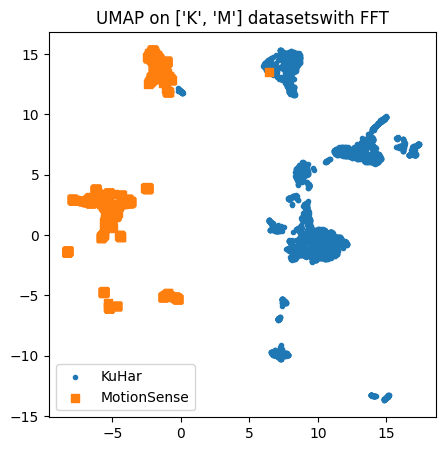

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


KuHar
MotionSense


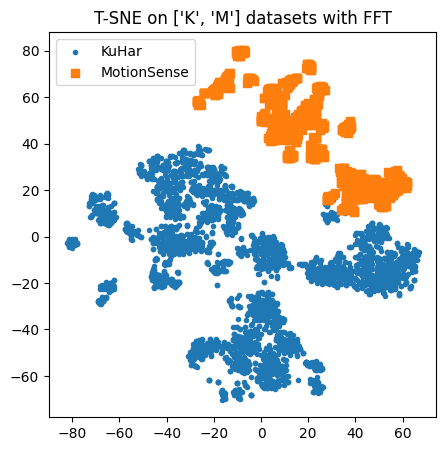

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


CHARM
KuHar


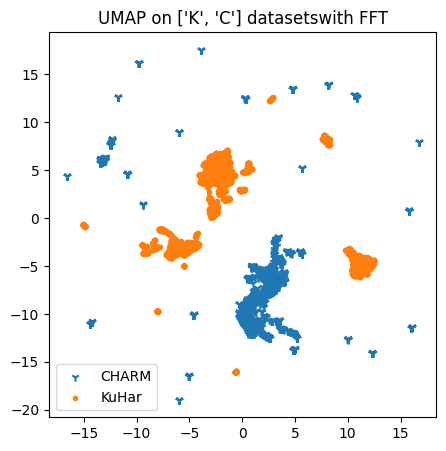

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CHARM
KuHar


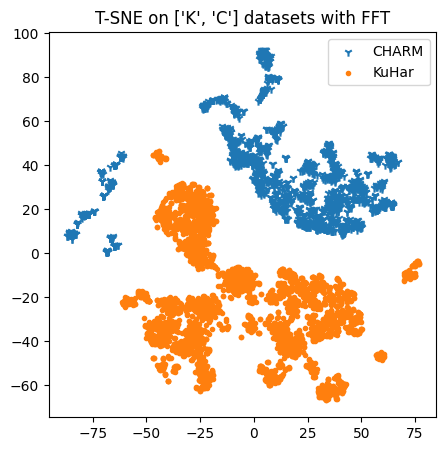

ExtraSensory
KuHar


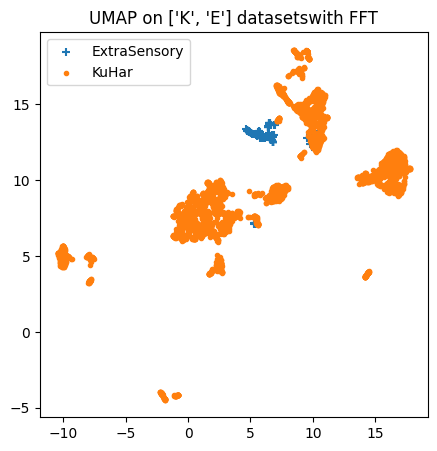

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


ExtraSensory
KuHar


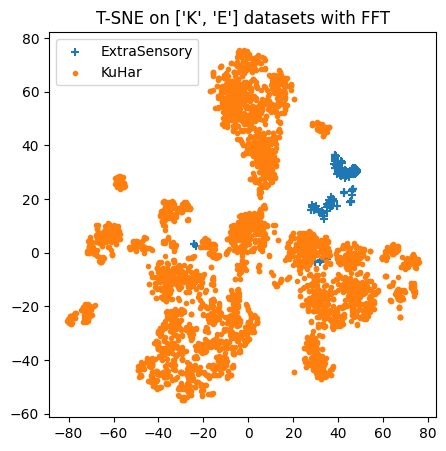

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


KuHar
WISDM


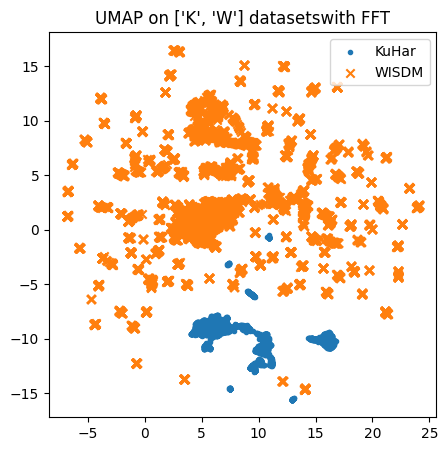

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


KuHar
WISDM


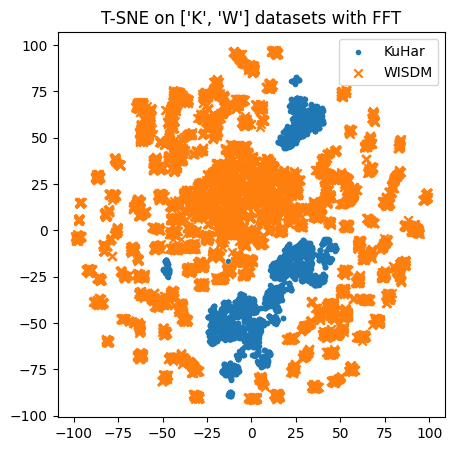

KuHar
UCI


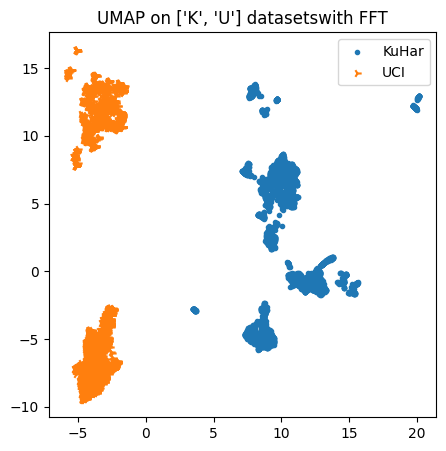

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


KuHar
UCI


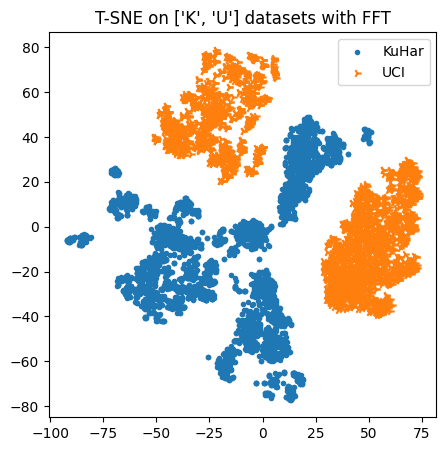

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


CHARM
MotionSense


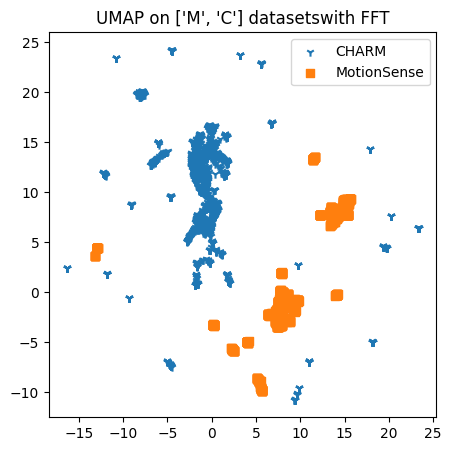

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CHARM
MotionSense


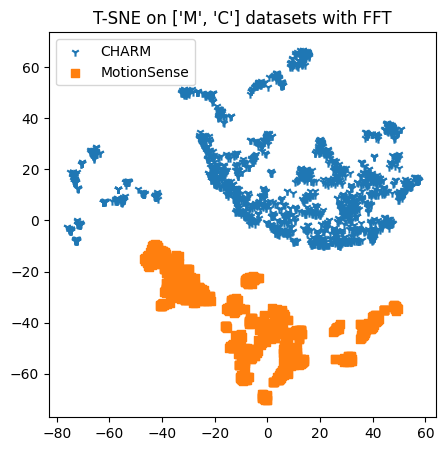

ExtraSensory
MotionSense


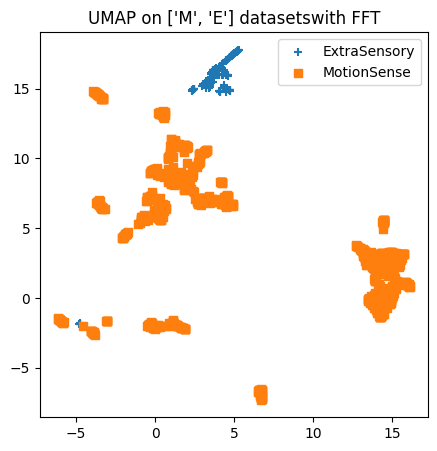

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


ExtraSensory
MotionSense


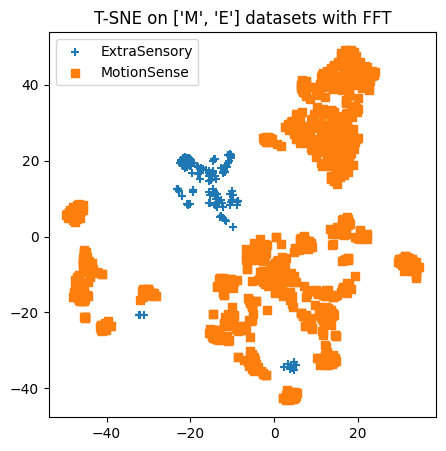

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


MotionSense
WISDM


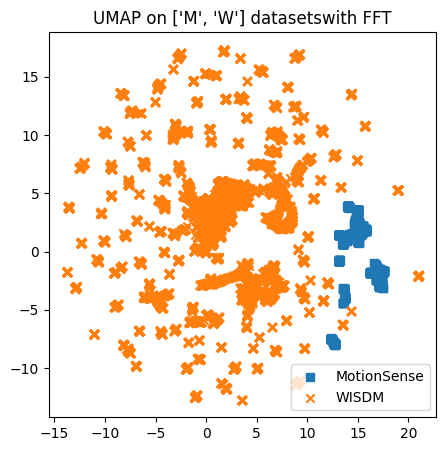

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


MotionSense
WISDM


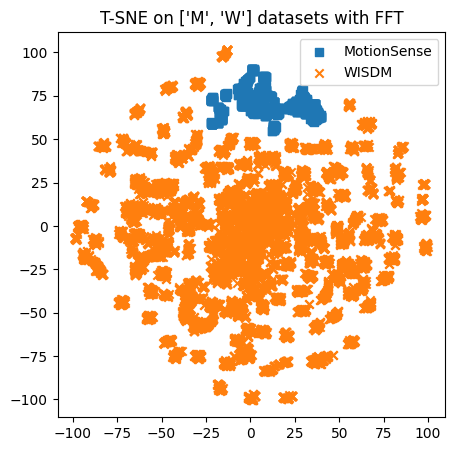

MotionSense
UCI


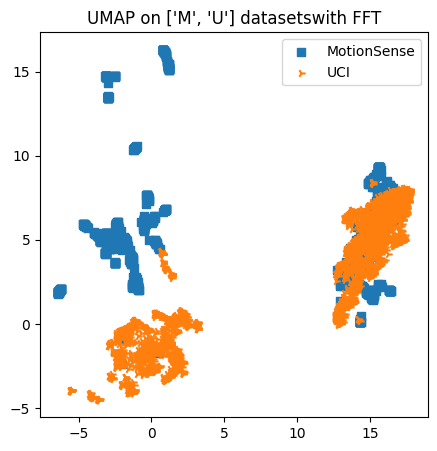

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


MotionSense
UCI


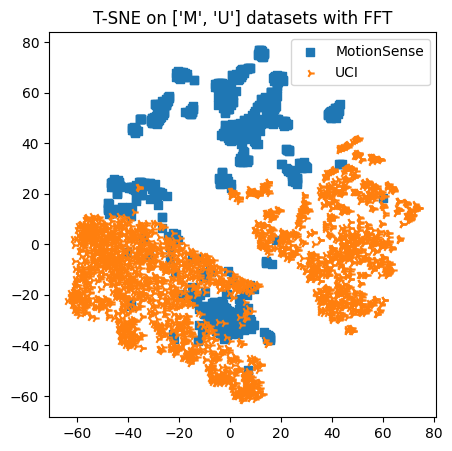

CHARM
ExtraSensory


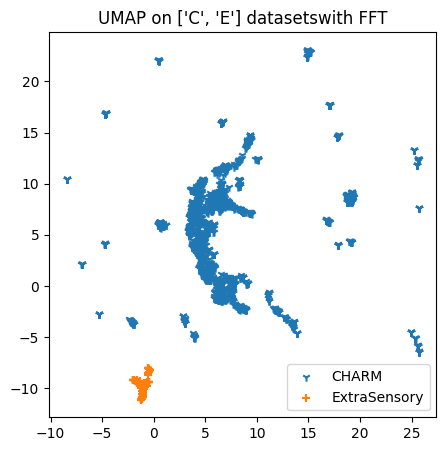

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CHARM
ExtraSensory


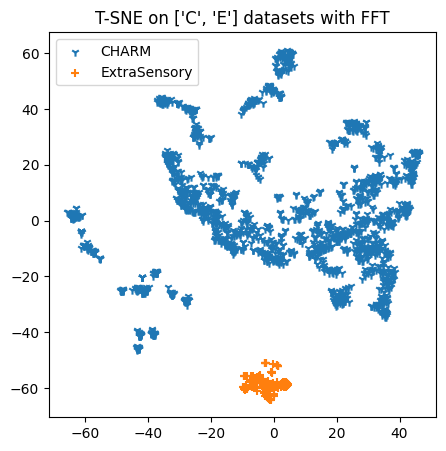

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


CHARM
WISDM


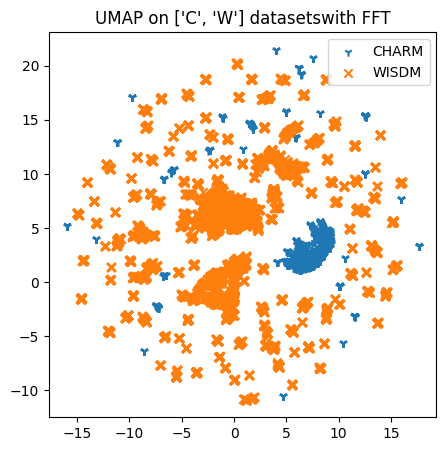

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CHARM
WISDM


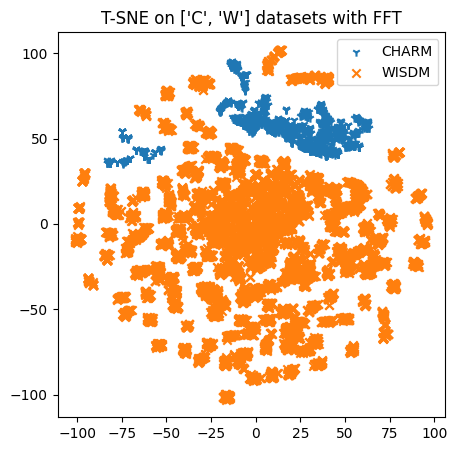

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


CHARM
UCI


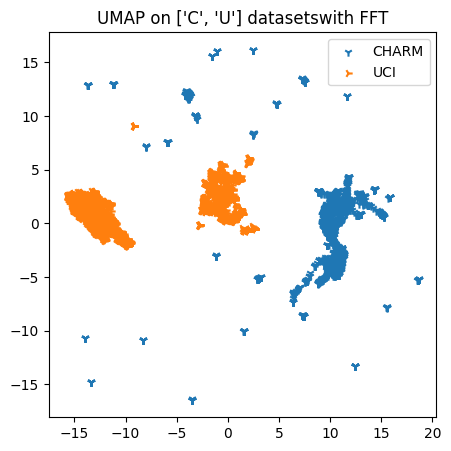

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CHARM
UCI


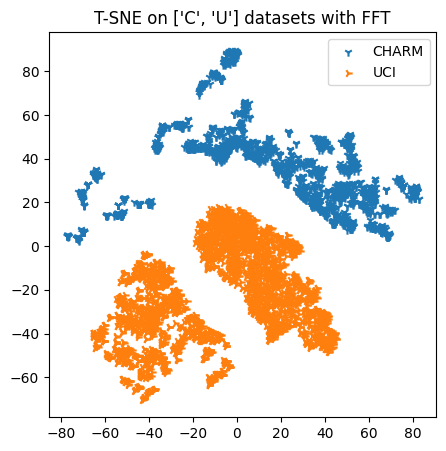

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


ExtraSensory
WISDM


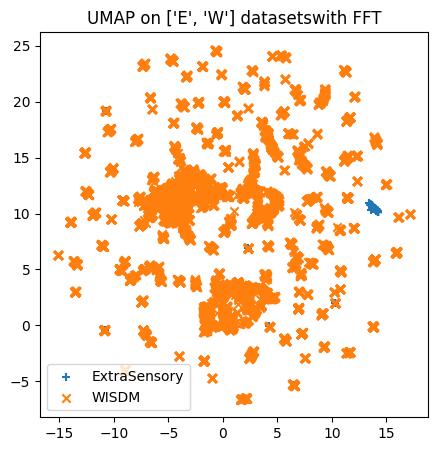

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


ExtraSensory
WISDM


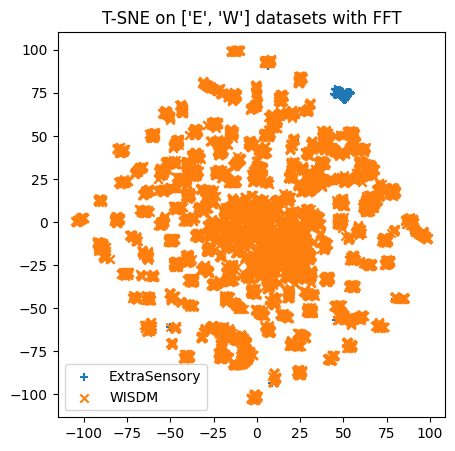

ExtraSensory
UCI


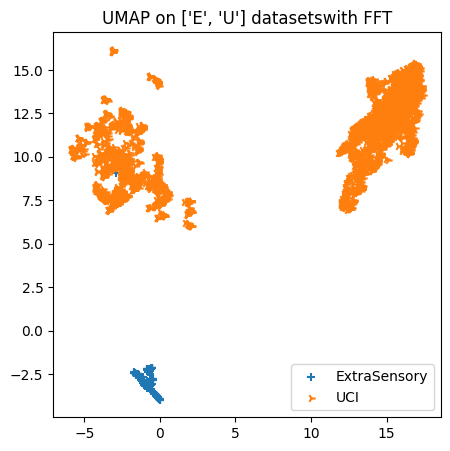

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


ExtraSensory
UCI


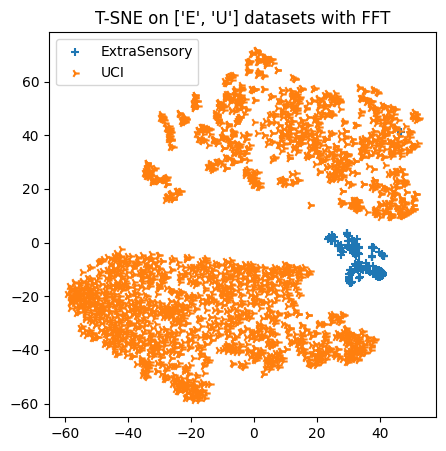

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


UCI
WISDM


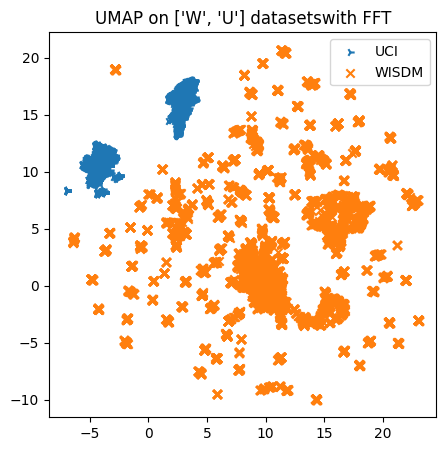

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


UCI
WISDM


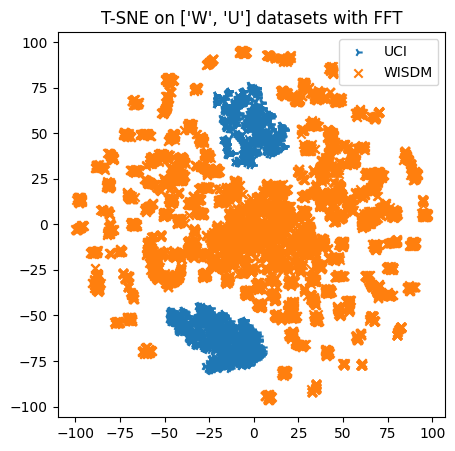

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


CHARM
ExtraSensory
KuHar
MotionSense
UCI
WISDM


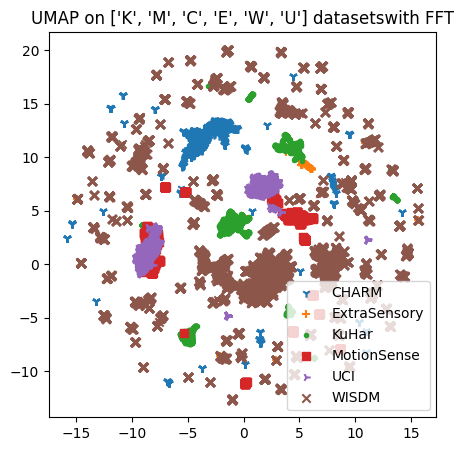

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CHARM
ExtraSensory
KuHar
MotionSense
UCI
WISDM


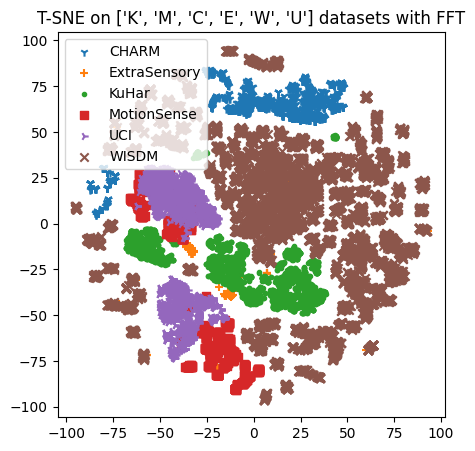

In [37]:
for combination in combinations:
    
    data_transformed = data[data['Id Dataset'].isin(combination)]

    # Creating the datasets
    data_transformed = PandasMultiModalDataset(
        data_transformed,
        feature_prefixes=features,
        label_columns="Id Dataset",
        as_array=True
    )
    
    data_fft = transformer(data_transformed)
    
    model = UMAP(n_components=2, random_state=42)
    result = pd.DataFrame(model.fit_transform(data_fft[:][0]), columns=["x", "y"])
    result["label"] = data_fft[:][1]
    plot(result, title="UMAP on {} datasetswith FFT".format(combination), labels = labels)
    
    model = TSNE(n_components=2, random_state=42)
    result = pd.DataFrame(model.fit_transform(data_fft[:][0]), columns=["x", "y"])
    result["label"] = data_fft[:][1]
    plot(result, title="T-SNE on {} datasets with FFT".format(combination), labels=labels)